# Convnet

Get CIFAR Dataset from https://www.cs.toronto.edu/~kriz/cifar.html

In [1]:
import pickle

def unpickle(file):
    import cPickle
    with open(file, 'rb') as fo:
        dict = cPickle.load(fo)
    return dict

- Reorganize the data so it’s a 32x32 matrix with 3 channels
- Grayscale the image by averaging the color intensities
- Crop the 32x32 image to a 24x24 image
- Normalize the pixels’ values by subtracting the mean and dividing by standard deviation

In [2]:
import numpy as np

def clean(data):
    imgs = data.reshape(data.shape[0], 3, 32, 32)
    grayscale_imgs = imgs.mean(1)
    cropped_imgs = grayscale_imgs[:, 4:28, 4:28]
    img_data = cropped_imgs.reshape(data.shape[0], -1) 
    img_size = np.shape(img_data)[1]
    means = np.mean(img_data, axis=1)
    meansT = means.reshape(len(means), 1)
    stds = np.std(img_data, axis=1)
    stdsT = stds.reshape(len(stds), 1)
    adj_stds = np.maximum(stdsT, 1.0 / np.sqrt(img_size)) 
    normalized = (img_data - meansT) / adj_stds
    return normalized

In [3]:
def read_data(directory):
    names = unpickle('{}/batches.meta'.format(directory))['label_names'] 
    print('names', names)
    
    data, labels = [], [] 
    for i in range(1, 6):
        filename = '{}/data_batch_{}'.format(directory, i) 
        batch_data = unpickle(filename)
        if len(data) > 0:
            data = np.vstack((data, batch_data['data']))
            labels = np.hstack((labels, batch_data['labels'])) 
        else:
            data = batch_data['data'] 
            labels = batch_data['labels']

    print(np.shape(data), np.shape(labels))

    data = clean(data)
    data = data.astype(np.float32) 
    return names, data, labels

Loading CIFAR Dataset

In [4]:
names, data, labels = read_data('/Users/faisal/ml-grad-course/datasets/cifar-10-batches-py')

('names', ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'])
((50000, 3072), (50000,))


Visualizing CIFAR Dataset

In [16]:
import numpy as np
import matplotlib.pyplot as plt
import random

def show_some_examples(names, data, labels):
    plt.figure(figsize=(8,8))
    rows, cols = 4, 4
    random_idxs = random.sample(range(len(data)), rows*cols)
    for i in range(rows * cols):
        plt.subplot(rows, cols, i+1)
        j = random_idxs[i]
        plt.title(names[labels[j]])
        img = np.reshape(data[j,:], (24,24))
        plt.imshow(img, cmap='gray_r')
        plt.axis('off')
    plt.tight_layout()
    plt.show()

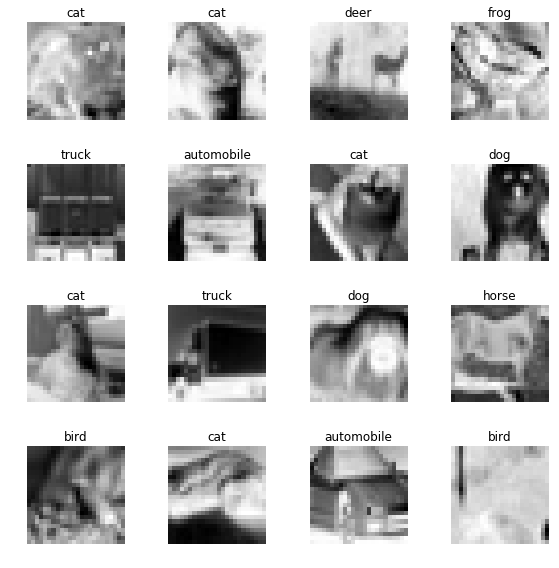

In [18]:
show_some_examples(names, data, labels)

## Convolution filters

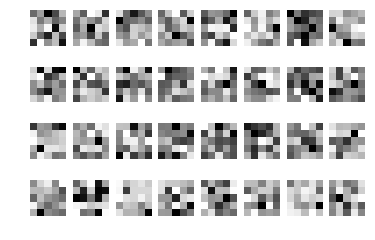

In [20]:
import tensorflow as tf

W = tf.Variable(tf.random_normal([5,5,1,32]))

def show_weights(W, filename=None):
    plt.figure()
    rows, cols = 4, 8
    for i in range(np.shape(W)[3]):
        img = W[:,:, 0, i]
        plt.subplot(rows, cols, i+1)
        plt.imshow(img, cmap='Greys_r', interpolation='none')
        plt.axis('off')
    if filename:
        plt.savefig(filename)
    else:
        plt.show()
        
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    W_val = sess.run(W)
    show_weights(W_val)

In [21]:
def show_conv_results(data, filename=None):
    plt.figure()
    rows, cols = 4, 8
    for i in range(np.shape(data)[3]):
        img = data[0,:,:,i]
        plt.subplot(rows, cols, i+1)
        plt.imshow(img, cmap='Greys_r', interpolation=None)
        plt.axis('off')
    if filename:
        plt.savefig(filename)
    else:
        plt.show()

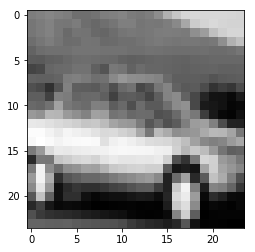

In [22]:
raw_data = data[4,:]
raw_img = np.reshape(raw_data, (24,24))
plt.figure()
plt.imshow(raw_img, cmap='Greys_r')
plt.show()

In [25]:
x = tf.reshape(raw_data, shape=[-1,24,24,1])
b = tf.Variable(tf.random_normal([32]))
conv = tf.nn.conv2d(x, W, strides=[1,1,1,1], padding='SAME')
conv_with_b = tf.nn.bias_add(conv, b)
conv_out = tf.nn.relu(conv_with_b)

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    conv_val = sess.run(conv)
    show_conv_results(conv_val, 'step1_convs.png')
    print(np.shape(conv_val))
    
    conv_out_val = sess.run(conv_out)
    show_conv_results(conv_out_val, 'step2_conv_outs.png')
    print(np.shape(conv_out_val))
    

(1, 24, 24, 32)
(1, 24, 24, 32)


In [26]:
x = tf.reshape(raw_data, shape=[-1,24,24,1])
b = tf.Variable(tf.random_normal([32]))
conv = tf.nn.conv2d(x, W, strides=[1,1,1,1], padding='SAME')
conv_with_b = tf.nn.bias_add(conv, b)
conv_out = tf.nn.relu(conv_with_b)

k = 2
maxpool = tf.nn.max_pool(conv_out, ksize=[1,k,k,1], strides=[1,k,k,1],padding='SAME')

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    maxpool_val = sess.run(maxpool)
    show_conv_results(maxpool_val, 'step3_maxpool.png')
    print(np.shape(maxpool_val))

(1, 12, 12, 32)


## Convnet

In [27]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

In [28]:
x = tf.placeholder(tf.float32, [None, 24*24])
y = tf.placeholder(tf.float32, [None, len(names)])

W1 = tf.Variable(tf.random_normal([5,5,1,64]))
b1 = tf.Variable(tf.random_normal([64]))

W2 = tf.Variable(tf.random_normal([5,5,64,64]))
b2 = tf.Variable(tf.random_normal([64]))

W3 = tf.Variable(tf.random_normal([6*6*64, 1024]))
b3 = tf.Variable(tf.random_normal([1024]))

W_out = tf.Variable(tf.random_normal([1024,len(names)]))
b_out = tf.Variable(tf.random_normal([len(names)]))

 
def conv_layer(x, W, b):
    conv = tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')
    conv_with_b = tf.nn.bias_add(conv, b)
    conv_out = tf.nn.relu(conv_with_b)
    return conv_out

def maxpool_layer(conv, k=2):
    return tf.nn.max_pool(conv, ksize=[1, k, k, 1], strides=[1, k, k, 1], padding='SAME')

def model():
    x_reshaped = tf.reshape(x, shape=[-1,24,24,1])
    
    conv_out1 = conv_layer(x_reshaped, W1, b1)
    maxpool_out1 = maxpool_layer(conv_out1)
    norm1 = tf.nn.lrn(maxpool_out1, 4, bias=1.0, alpha=0.001/9.0, beta=0.75)

    conv_out2 = conv_layer(norm1, W2, b2)
    norm2 = tf.nn.lrn(conv_out2, 4, bias=1.0, alpha=0.001/9.0, beta=0.75)
    maxpool_out2 = maxpool_layer(norm2)
    
    maxpool_reshaped = tf.reshape(maxpool_out2, [-1, W3.get_shape().as_list()[0]])
    local = tf.add(tf.matmul(maxpool_reshaped, W3), b3)
    local_out = tf.nn.relu(local)
    
    out = tf.add(tf.matmul(local_out, W_out), b_out)
    return out

In [29]:
model_op = model()

cost = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(logits=model_op, labels=y)
)

train_op = tf.train.AdamOptimizer(learning_rate = 0.001).minimize(cost)

correct_pred = tf.equal(tf.argmax(model_op,1), tf.argmax(y,1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

In [ ]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    onehot_labels = tf.one_hot(labels, len(names), on_value=1., off_value=0., axis=-1)
    onehot_vals = sess.run(onehot_labels)
    batch_size = len(data) // 200
    print ('batch_size', batch_size)
    
    for j in range(0, 1000):
        print ('EPOCH', j)
        for i in range(0, len(data), batch_size):
            batch_data = data[i:i+batch_size, :]
            batch_onehot_vals = onehot_vals[i:i+batch_size, :]
            _, accuracy_val = sess.run([train_op, accuracy], feed_dict={x: batch_data, y: batch_onehot_vals})
            if i % 1000 == 0:
                print (i, accuracy_val)
        print ('DONE WITH EPOCH')

('batch_size', 250)
('EPOCH', 0)
(0, 0.064000003)
(1000, 0.1)
(2000, 0.083999999)
(3000, 0.156)
(4000, 0.148)
(5000, 0.13600001)
(6000, 0.108)
(7000, 0.168)
(8000, 0.192)
(9000, 0.12)
(10000, 0.168)
(11000, 0.14)
(12000, 0.152)
(13000, 0.168)
(14000, 0.164)
(15000, 0.164)
(16000, 0.228)
(17000, 0.21600001)
(18000, 0.22400001)
(19000, 0.18000001)
(20000, 0.192)
(21000, 0.168)
(22000, 0.14399999)
(23000, 0.208)
(24000, 0.22400001)
(25000, 0.17200001)
(26000, 0.212)
(27000, 0.22)
(28000, 0.18799999)
(29000, 0.22400001)
(30000, 0.22400001)
(31000, 0.22400001)
(32000, 0.212)
(33000, 0.25999999)
(34000, 0.2)
(35000, 0.212)
(36000, 0.25600001)
(37000, 0.212)
(38000, 0.23999999)
(39000, 0.21600001)
(40000, 0.212)
(41000, 0.18799999)
(42000, 0.22400001)
(43000, 0.22)
(44000, 0.22)
(45000, 0.28400001)
(46000, 0.28)
(47000, 0.252)
(48000, 0.208)
(49000, 0.264)
DONE WITH EPOCH
('EPOCH', 1)
(0, 0.248)
(1000, 0.25600001)
(2000, 0.23199999)
(3000, 0.244)
(4000, 0.26800001)
(5000, 0.204)
(6000, 0.2399

In [ ]:
import tensorflow as tf
import tfgraphviz as tfg
a = tf.constant(1, name="a")
b = tf.constant(2, name="b")
c = tf.add(a, b, name="add")
g = tfg.board(tf.get_default_graph())
g.view()